In [5]:
# --- Library ---
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [6]:
# --- Feature Engineering Function ---
def create_features(data):
    data = data.copy()
    data['pernah_dihubungi_sebelumnya'] = np.where(
        data['hari_sejak_kontak_sebelumnya'] == 999, 0, 1)
    data['rasio_sukses_sebelumnya'] = (
        data['hasil_kampanye_sebelumnya'].map({'success': 1, 'failure': 0, 'nonexistent': 0}) *
        (data['jumlah_kontak_sebelumnya'] + 1)
    )
    data['risk_score'] = (
        0.4 * data['indeks_harga_konsumen'] +
        0.3 * data['suku_bunga_euribor_3bln'] +
        0.3 * data['tingkat_variasi_pekerjaan']
    )
    data['usia_group'] = pd.cut(
        data['usia'], bins=[18, 30, 45, 60, 100],
        labels=['muda', 'paruhbaya', 'senior', 'lansia']
    )
    data['beban_pinjaman'] = (
        data['pinjaman_rumah'].map({'yes': 1, 'no': 0, 'unknown': 0}) +
        data['pinjaman_pribadi'].map({'yes': 1, 'no': 0, 'unknown': 0})
    )
    return data

In [7]:
# --- Load and preprocess data ---
df = pd.read_csv("training_dataset.csv")
df = create_features(df)

target = "berlangganan_deposito"
features = [col for col in df.columns if col != target and col != "customer_number"]

X_full = df[features]
y_full = df[target]

In [8]:
# --- Preprocessor ---
NUM_FEATURES = ['usia', 'jumlah_kontak_kampanye_ini', 'indeks_harga_konsumen',
                'suku_bunga_euribor_3bln', 'rasio_sukses_sebelumnya', 'risk_score']
CAT_FEATURES = ['pekerjaan', 'status_perkawinan', 'pendidikan', 'jenis_kontak',
                'pulau', 'usia_group', 'pernah_dihubungi_sebelumnya']
# --- Split Train/Validation/Test ---
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), NUM_FEATURES),
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES)
])

In [9]:
# --- Objective for Optuna ---
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 400),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1, 8),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'random_state': 42
    }

    model = ImbPipeline([
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()


In [10]:
# --- Run Optuna Study ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best ROC-AUC:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-05-26 15:17:37,954] A new study created in memory with name: no-name-bb8d914d-47ad-4fe5-8b7a-7644cbc912d1
[I 2025-05-26 15:17:46,470] Trial 0 finished with value: 0.7736457543422323 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.14684312380991227, 'subsample': 0.8161276879743953, 'colsample_bytree': 0.9100589424196492, 'scale_pos_weight': 3.3141196030247175}. Best is trial 0 with value: 0.7736457543422323.
[I 2025-05-26 15:17:52,318] Trial 1 finished with value: 0.7852460353105533 and parameters: {'n_estimators': 358, 'max_depth': 5, 'learning_rate': 0.01214318129076084, 'subsample': 0.769731226067226, 'colsample_bytree': 0.5214743092988274, 'scale_pos_weight': 3.384878811425343}. Best is trial 1 with value: 0.7852460353105533.
[I 2025-05-26 15:17:54,149] Trial 2 finished with value: 0.7793807121023907 and parameters: {'n_estimators': 159, 'max_depth': 3, 'learning_rate': 0.027021737382351453, 'subsample': 0.6904066875855979, 'colsample_bytree': 0.8885

Best ROC-AUC: 0.7911591904435618
Best Parameters: {'n_estimators': 297, 'max_depth': 7, 'learning_rate': 0.038438295368358175, 'subsample': 0.8503040225883528, 'colsample_bytree': 0.7367022361839719, 'scale_pos_weight': 1.5263215815843933}


In [11]:
# --- Final Model ---
best_params = study.best_params
best_params.update({'tree_method': 'hist', 'use_label_encoder': False, 'random_state': 42})

final_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(**best_params))
])
final_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['usia',
                                                   'jumlah_kontak_kampanye_ini',
                                                   'indeks_harga_konsumen',
                                                   'suku_bunga_euribor_3bln',
                                                   'rasio_sukses_sebelumnya',
                                                   'risk_score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pekerjaan',
                                                   'status_perkawinan',
                                                   'pendidikan', 'jenis_kontak',
                                                   'pulau', 'usia_group',
                                                   'pernah_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.038438295368358175, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=297,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [12]:
# --- Evaluation on Test Set ---
y_test_proba = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print("Test ROC-AUC:", roc_auc)

Test ROC-AUC: 0.7996909964515526


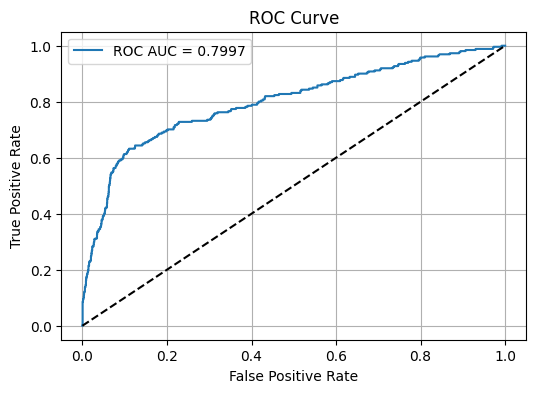

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

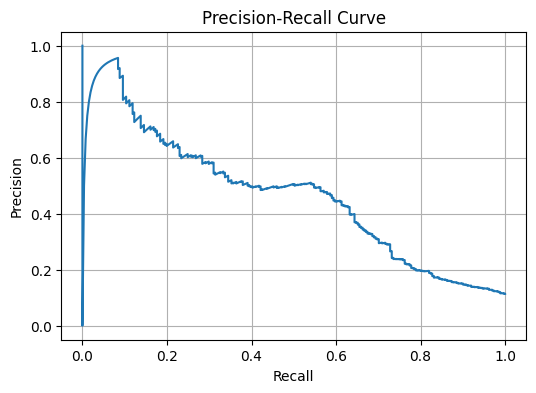

In [14]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [15]:
# --- Final Prediction for Submission ---
val = pd.read_csv("validation_set.csv")
val = create_features(val)
X_val_final = val[features]
y_pred_prob = final_model.predict_proba(X_val_final)[:, 1]

submission = pd.DataFrame({
    "customer_number": val["customer_number"],
    "berlangganan_deposito": y_pred_prob
})
submission.to_csv("submission.csv", index=False)